In [1]:
from typing import List, Tuple, Dict, Any, Optional
from multiprocessing import Pool
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
BASE_PATH = "../program_bank/v040/2025_02_24__14_25"  # 1h - 3 platforms
# BASE_PATH = "../program_bank/v038/2025_02_22__23_13"  # 100 programs - 3 platforms

PY_COVERAGE_PATH = os.path.join(BASE_PATH, "coverage.xml")
RUST_COVERAGE_PATH = os.path.join(BASE_PATH, "rust_coverage.xml")

MERGED_COVERAGE_PATH = os.path.join(BASE_PATH, "merged_coverage.xml")


# 1 h
MORPHQ_PATH = "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v14"

# 5 min
# MORPHQ_PATH = "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v13"
MORPHQ_COVERAGE_PATH = os.path.join(MORPHQ_PATH, "coverage.xml")
MORPHQ_RUST_COVERAGE_PATH = os.path.join(MORPHQ_PATH, "rust_coverage.xml")

MORPHQ_MERGED_COVERAGE_PATH = os.path.join(MORPHQ_PATH, "merged_coverage.xml")

platforms = [
    'qiskit', 'pennylane', 'pytket',
    # 'bqskit'
]

In [3]:
import xml.etree.ElementTree as ET


def merge_cobertura_reports(report1_path, report2_path, output_path):
    tree1 = ET.parse(report1_path)
    root1 = tree1.getroot()

    tree2 = ET.parse(report2_path)
    root2 = tree2.getroot()

    # Merge `<packages>` elements
    packages1 = root1.find("packages")
    packages2 = root2.find("packages")

    if packages1 is not None and packages2 is not None:
        for package in packages2.findall("package"):
            packages1.append(package)

    # Save merged XML
    tree1.write(output_path)


merge_cobertura_reports(
    report1_path=PY_COVERAGE_PATH,
    report2_path=RUST_COVERAGE_PATH,
    output_path=MERGED_COVERAGE_PATH
)

merge_cobertura_reports(
    report1_path=MORPHQ_COVERAGE_PATH,
    report2_path=MORPHQ_RUST_COVERAGE_PATH,
    output_path=MORPHQ_MERGED_COVERAGE_PATH
)

In [4]:
def get_coverage_info(platforms: List[str],
                      coverage_path: str) -> Dict[str, Dict[str, Any]]:
    """
    Given a list of platforms, returns the coverage information for each platform.

    Args:
        platforms (List[str]): List of platform names to extract coverage information for.
        coverage_path (str): Path to the coverage XML file.

    Returns:
        Dict[str, Dict[str, Any]]: Dictionary containing coverage information for each platform.
    """
    import xml.etree.ElementTree as ET

    # Parse the coverage.xml file
    tree = ET.parse(coverage_path)
    root = tree.getroot()

    # Initialize counters for each package
    package_coverage = {platform: {'covered': 0, 'total': 0}
                        for platform in platforms}
    qiskit_lines = []
    covered_qiskit_lines = []

    # Extract package information
    packages = root.find('packages')
    for package in packages.findall('package'):
        package_name = package.get('name')

        # Extract class information
        classes = package.find('classes')
        for cls_obj in classes.findall('class'):
            # Extract line information
            lines = cls_obj.find('lines')
            for line in lines.findall('line'):
                hits = int(line.get('hits'))
                package_key = None
                for platform_name in package_coverage.keys():
                    if f"/site-packages/{platform_name}/" in cls_obj.get(
                            'filename'):
                        package_key = platform_name
                        break
                if "crates" in package_name:
                    package_key = "qiskit"
                if package_key is None:
                    # by default the colletion of coverage done from the
                    # qiskit installation folder have relative paths
                    # thus they refer to the qiskit package
                    package_key = "qiskit"
                if package_key:
                    package_coverage[package_key]['total'] += 1
                    if package_key == "qiskit":
                        new_qiskit_line = f"{cls_obj.get('filename')}:{line.get('number')}"
                        new_qiskit_line = new_qiskit_line.replace(
                            "/home/regularuser/qiskit/qiskit/", "")
                        qiskit_lines.append(new_qiskit_line)
                        if hits > 0:
                            covered_qiskit_lines.append(new_qiskit_line)

                    if hits > 0:
                        package_coverage[package_key]['covered'] += 1

    # Add percentage coverage
    for package, coverage in package_coverage.items():
        total_lines = coverage['total']
        covered_lines = coverage['covered']
        coverage_percentage = (
            covered_lines / total_lines) * 100 if total_lines > 0 else 0
        package_coverage[package]['coverage'] = coverage_percentage

    return package_coverage, qiskit_lines, covered_qiskit_lines


package_coverage_ours, qiskit_lines_ours, covered_lines_our_approach = get_coverage_info(
    platforms, MERGED_COVERAGE_PATH)
for package, coverage in package_coverage_ours.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")
qiskit_lines_ours[:5]

qiskit_________: 10.61% (7735/72892)
pennylane______: 2.31% (1168/50666)
pytket_________: 5.87% (279/4750)


['__init__.py:17',
 '__init__.py:18',
 '__init__.py:19',
 '__init__.py:20',
 '__init__.py:21']

In [5]:

package_coverage_morphq, qiskit_lines_morphq, covered_lines_morphq_1h = get_coverage_info(
    platforms, MORPHQ_MERGED_COVERAGE_PATH)
for package, coverage in package_coverage_morphq.items():
    print(
        f"{package:_<15}: {coverage['coverage']:.2f}% ({coverage['covered']}/{coverage['total']})")
qiskit_lines_morphq[:5]

qiskit_________: 9.47% (6904/72892)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)


['__init__.py:17',
 '__init__.py:18',
 '__init__.py:19',
 '__init__.py:20',
 '__init__.py:21']

In [6]:
# check the difference in the two sets of qiskit lines in terms of size and print some
ours_set = set(qiskit_lines_ours)
morphq_set = set(qiskit_lines_morphq)

# Difference in sizes
print(f"Size of qiskit_lines_ours: {len(ours_set)}")
print(f"Size of qiskit_lines_morphq: {len(morphq_set)}")

# Lines present in ours but not in morphq
diff_ours = ours_set - morphq_set
print(f"Lines in ours but not in morphq: {len(diff_ours)}")
print(sorted(diff_ours)[:5])

# Lines present in morphq but not in ours
diff_morphq = morphq_set - ours_set
print(f"Lines in morphq but not in ours: {len(diff_morphq)}")
print(sorted(diff_morphq)[:5])

Size of qiskit_lines_ours: 72892
Size of qiskit_lines_morphq: 72892
Lines in ours but not in morphq: 0
[]
Lines in morphq but not in ours: 0
[]


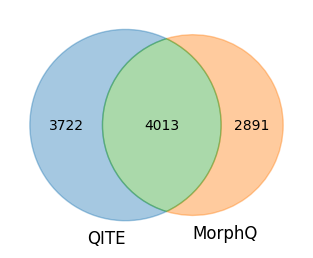

\newcommand{\QITEQiskitCoverage}{10.61\%}
\newcommand{\MorphQQiskitCoverage}{9.47\%}
\newcommand{\QITEQiskitTotalLines}{72892}
\newcommand{\MorphQQiskitTotalLines}{72892}
\newcommand{\QITEQiskitCoveredLines}{7735}
\newcommand{\MorphQQiskitCoveredLines}{6904}
\newcommand{\CoveredSharedLines}{4013}
\newcommand{\CoveredOnlyQITE}{3722}
\newcommand{\CoveredOnlyMorphQ}{2891}


In [7]:
from matplotlib_venn import venn2
import seaborn as sns

import matplotlib.pyplot as plt


def plot_covered_lines_venn(
        set1: set, set2: set, label1: str, label2: str) -> Tuple[
        plt.Figure, plt.Axes]:
    """
    Plot a Venn diagram showing the intersection between two sets of covered lines.

    Args:
        set1 (set): First set of covered lines.
        set2 (set): Second set of covered lines.
        label1 (str): Label for the first set.
        label2 (str): Label for the second set.

    Returns:
        Tuple[plt.Figure, plt.Axes]: The figure and axes of the Venn diagram.
    """
    # Compute the intersection and differences
    only_set1 = set1 - set2
    only_set2 = set2 - set1
    intersection = set1 & set2

    # Create the Venn diagram
    fig, ax = plt.subplots(figsize=(6, 3))
    venn = venn2([set1, set2], (label1, label2), ax=ax)

    # Set colors using seaborn palette
    colors = sns.color_palette("tab10", 3)
    venn.get_label_by_id('10').set_text(len(only_set1))
    venn.get_label_by_id('01').set_text(len(only_set2))
    venn.get_label_by_id('11').set_text(len(intersection))

    # Set colors
    venn.get_patch_by_id('10').set_color(colors[0])
    venn.get_patch_by_id('01').set_color(colors[1])
    venn.get_patch_by_id('11').set_color(colors[2])

    # Add title
    plt.show()

    return fig, ax


# Example usage
set_our_approach = set(covered_lines_our_approach)
set_morphq = set(covered_lines_morphq_1h)
fig, ax = plot_covered_lines_venn(
    set_our_approach, set_morphq, 'QITE', 'MorphQ')

# Save the Venn diagram as an image with a meaningful name
output_path_venn = os.path.join(
    "images", "comparison_morphq_covered_lines_venn_w_rust.pdf")
fig.savefig(output_path_venn)

print(
    f"\\newcommand{{\\QITEQiskitCoverage}}{{{package_coverage_ours['qiskit']['coverage']:.2f}\\%}}")
print(
    f"\\newcommand{{\\MorphQQiskitCoverage}}{{{package_coverage_morphq['qiskit']['coverage']:.2f}\\%}}")

print(
    f"\\newcommand{{\\QITEQiskitTotalLines}}{{{package_coverage_ours['qiskit']['total']}}}")
print(
    f"\\newcommand{{\\MorphQQiskitTotalLines}}{{{package_coverage_morphq['qiskit']['total']}}}")

print(
    f"\\newcommand{{\\QITEQiskitCoveredLines}}{{{package_coverage_ours['qiskit']['covered']}}}")
print(
    f"\\newcommand{{\\MorphQQiskitCoveredLines}}{{{package_coverage_morphq['qiskit']['covered']}}}")

# Calculate the number of lines in each category
num_shared_lines = len(set_our_approach & set_morphq)
num_only_qite = len(set_our_approach - set_morphq)
num_only_morphq = len(set_morphq - set_our_approach)

print(f"\\newcommand{{\\CoveredSharedLines}}{{{num_shared_lines}}}")
print(f"\\newcommand{{\\CoveredOnlyQITE}}{{{num_only_qite}}}")
print(f"\\newcommand{{\\CoveredOnlyMorphQ}}{{{num_only_morphq}}}")

In [18]:
import subprocess
from functools import lru_cache


@lru_cache(maxsize=128)
def get_docker_file_line_info(file_path: str, line_number: str) -> str:
    command = f"docker run --rm qiskit_w_rust /bin/bash -c \"sed -n '{line_number}p' {file_path}\""
    result = subprocess.run(command, shell=True,
                            capture_output=True, text=True)
    return result.stdout.strip()


for line in sorted(diff_morphq)[:25]:
    file_path, line_number = line.split(':')
    file_path = f"qiskit/{file_path}"
    print("-" * 80)
    print(line)
    print(get_docker_file_line_info(file_path, line_number))

--------------------------------------------------------------------------------
circuit/bit.py:60
def __repr__(self):
--------------------------------------------------------------------------------
circuit/bit.py:62
if (self._register, self._index) == (None, None):
--------------------------------------------------------------------------------
circuit/bit.py:64
return object.__repr__(self)
--------------------------------------------------------------------------------
circuit/bit.py:65
return self._repr
--------------------------------------------------------------------------------
circuit/classical/expr/expr.py:106
def __repr__(self):
--------------------------------------------------------------------------------
circuit/classical/expr/expr.py:107
return f"Cast({self.operand}, {self.type}, implicit={self.implicit})"
--------------------------------------------------------------------------------
circuit/classical/expr/expr.py:177
def __repr__(self):
-----------------------------